# CTR Analysis Ver3
from 24/04/10

In [352]:
%reset -f
import numpy as np
# from scipy.constants import h, c, e, pi
# from scipy.linalg import inv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from fractions import Fraction
import traceback
import json

In [353]:
##### ##### ##### ##### ##### ##### #####
exp  = lambda rad: np.exp(rad)
sin  = lambda rad: np.sin(rad)
cos  = lambda rad: np.cos(rad)
tan  = lambda rad: np.tan(rad)
asin = lambda rad: np.arcsin(rad)
acos = lambda rad: np.arccos(rad)
#
sqrt   = lambda vec: np.sqrt(vec)
norm   = lambda vec: np.linalg.norm(vec)
square = lambda vec: np.power(vec, 2)
##### ##### ##### ##### ##### ##### #####
def vec(*args): return np.array([*args])
def uvec(*args): 
    vec = np.array([*args])
    return  vec / np.linalg.norm(vec)
#
def prod(RES):
    INF = np.where(np.isinf(RES))
    RES[INF] = 0
    PRD = np.prod(RES, axis=1)
    if INF[0].size != 0: PRD[INF[0]] = inf
    return PRD
##### ##### ##### ##### ##### ##### #####
pi   = np.pi
inf  = np.inf
#
eps0 = 8.854187817E-12

In [354]:
def cube3d(arr, dim=0b001):
    if dim == 0b100:   return np.transpose(np.array(arr),(0, 2, 1))[:,:,::-1]
    elif dim == 0b010: return np.transpose(np.array(arr),(2, 0, 1))[::-1,:,::-1]
    elif dim == 0b001: return np.transpose(np.array(arr),(1, 2, 0))[:,:,::-1]
    else: return

def cuberange(X, Y, Z):
    for i in range(X):
        for j in range(Y):
            for k in range(Z):
                yield (i, j, k)

def span(eigenValues, eigenVector):
    return np.tensordot(eigenValues, eigenVector, axes=0)


In [355]:
def PIticks(start, end, step):
    v = np.arange(start, end+step, step)
    txt = []
    for ii in v:
        f = Fraction(ii)
        if f==0:
            txt.append(0)
            continue
        #
        if   f.numerator ==  1: num = 'π'
        elif f.numerator == -1: num = '-π'
        else: num = f'{f.numerator}π'
        #
        if f.denominator == 1: txt.append(num)
        else : txt.append(f'{num}/{f.denominator}')
    return v*pi, txt

---

In [356]:
# https://lampz.tugraz.at/~hadley/ss1/crystaldiffraction/atomicformfactors/formfactors.php
file_path = "./JSON/AFF.json"  # 파일 경로
with open(file_path, "r") as f:
	AtomicFormFactor = json.load(f)

---
# Class

In [357]:
class Xray():
    CuKa1 = 1.5406
    def __init__(self, wavelength = 1.5406):
        self.wavelength = wavelength # Å unit
        self.K = 2 * pi / wavelength
    def __call__(self, *args):
        return self.K
    def tthetas2dks(self, tthetas):
        return 2 * self.K * sin(tthetas/2)
# Usage
CuKa1 = Xray(Xray.CuKa1)

In [358]:
class Atom():
    def __init__(self, Z, def_name = None):
        self.Z = Z
        if def_name == None:
            (_,_,_,text)=traceback.extract_stack()[-2]
            def_name = text[:text.find('=')].strip()
        self.def_name = def_name
    def __call__(self):
        return self.def_name
    def __truediv__(self, num):
        return Atom(self.Z / num.Z, def_name=self.def_name)

# Usage
Sr = Atom(38)
Ti = Atom(22)
O  = Atom(8)
Ru = Atom(44)
Nd = Atom(60)
Ni = Atom(28)
Ga = Atom(31)

In [359]:
class Molecule():
    def __init__(self, structure, abc, def_name = None):
        self.structure = structure
        self.abc = vec(*abc)
        if def_name == None:
            (_,_,_,text)=traceback.extract_stack()[-2]
            def_name  = text[:text.find('=')].strip()
        self.def_name = def_name
    def __call__(self, *args):
        if len(args)>0:
            return {self.def_name: vec(*args)}
        return self.def_name
    #
    def perovskite(A, B, O): # Atoms
        A /= Atom(8)
        O /= Atom(2)
        return cube3d([
            [[A, 0, A], [0, O, 0], [A, 0, A]],
            [[0, O, 0], [O, B, O], [0, O, 0]],
            [[A, 0, A], [0, O, 0], [A, 0, A]]
        ], 0b100)
    def pseudocubic(*abc):
        a, b, c = abc
        ac      = np.sqrt(a**2 + b**2) / 2
        cc      = c / 2
        return np.array((ac, ac, cc))
    def const_volume_abc(self, film_abc):
        a, b, _ = self.abc
        return np.array([a, b, np.prod(film_abc) / (a*b)])
    def strain(self, film):
        return Molecule(
            structure = film.structure,
            abc = self.const_volume_abc(film.abc)
        )
    def __truediv__(self, substrate):
        return Molecule(
            structure = self.structure,
            abc = substrate.const_volume_abc(self.abc),
            def_name  = self.def_name + '/' + substrate.def_name
    )
    #
    def GG2HKL(self, GG, nref=vec(0,0,1)):
        nref = uvec(*nref)
        QQ   = span(GG, nref)
        # Q * abc = 2 * pi * hkl
        HKL = QQ * self.abc / 2 / pi
        return HKL
    # def hkls2Gs(self, hkls):
    #     return np.linalg.norm(2 * pi * hkls / self.abc , axis = 1)

# Usage
sto = Molecule(
    structure = Molecule.perovskite(Sr, Ti, O),
    abc = (3.905, 3.905, 3.905)
)
sro = Molecule(
    structure = Molecule.perovskite(Sr, Ru, O),
    abc = Molecule.pseudocubic(5.567, 5.5304, 7.8446)
)
nno = Molecule(
    structure = Molecule.perovskite(Nd, Ni, O),
    abc = Molecule.pseudocubic(5.387, 5.383, 7.610)
)
ngo = Molecule(
    structure = Molecule.perovskite(Nd, Ni, O),
    abc = Molecule.pseudocubic(5.428, 5.498, 7.708)
)
sro_sto = sro/sto # sto.strain(sro)
nno_sto = nno/sto # sto.strain(nno)
ngo_sto = ngo/sto # sto.strain(ngo)

In [360]:
class Film():
    def __init__(self, molecule, NaNbNc, configuration = []):
        self.molecule = molecule
        self.NaNbNc = NaNbNc
        self.Na, self.Nb, self.Nc = NaNbNc
        #
        self.configuration = configuration

    def __call__(self, *args):
        if len(args)>0:
            return self.molecule(*args)
        return self.molecule()

    def __truediv__(self, substrate):
        return Film(self.molecule, self.NaNbNc, [*self.configuration, substrate])
    
class Sample():
    def __init__(self, top_film):
        if top_film.configuration == []:
            self.films = [top_film]
        else:
            self.films = [top_film, *top_film.configuration]
        self.bulk = self.films.pop()
    def __call__(self):
        return vec(*[x() for x in self.films], self.bulk())

# Usage
STO = Film(sto, (10, 10, 100))
SRO = Film(sro, (10, 10, 10))
NNO = Film(nno, (10, 10, 10))
NGO = Film(ngo, (10, 10, 10))
#
SRO_sto = Film(sro/sto, (10, 10, 100))
NNO_sto = Film(nno/sto, (10, 10, 100))
##
SRO_STO = Sample(SRO_sto/STO)
NNO_SRO_STO = Sample(NNO_sto/SRO_sto/STO)

# SAMP = Sample(SRO)
print('Total Configuration )')
print(NNO_SRO_STO())
print(f'BULK )  {NNO_SRO_STO.bulk()}')
print(f'FILM )  {vec(*[x() for x in NNO_SRO_STO.films])}')

Total Configuration )
['nno/sto' 'sro/sto' 'sto']
BULK )  sto
FILM )  ['nno/sto' 'sro/sto']


---

In [361]:
class Detector:
    def __init__(self, xray, atom=[], molecule=[], film=[], sample=[]):
        if str(atom.__class__) == "<class '__main__.Atom'>": self.atom = vec(atom)
        else : self.atom = vec(*atom)
        #
        if str(molecule.__class__) == "<class '__main__.Molecule'>": self.molecule = vec(molecule)
        else: self.molecule = vec(*molecule)

        if str(film.__class__) == "<class '__main__.Film'>": self.film = vec(film)
        else: self.film = vec(*film)

        self.sample   = sample
        self.HKL = {}
        #
        self.xray     = xray
        self.TTHETA   = np.linspace(1E-10, pi, 1000)
        self.DEGREE   = np.rad2deg(self.TTHETA)
        self.DK       = xray.tthetas2dks(self.TTHETA)
        self.nref     = {}
        self.loc      = (1, 1, 1)

    def align(self, nref):
        # nref = {'sto': (0, 0, 1)}  또는  sto(0, 0, 1)
        if str(nref.__class__) == "<class 'dict'>":
            self.nref = nref
        # nref = [sto(0,0,1), nno(0,0,2)]
        elif str(nref[0].__class__) == "<class 'dict'>":
            self.nref = dict((key, value) for dictionary in nref for key, value in dictionary.items())
        else: 
            print('ERROR_')
            print("EX) align(nref=Molecule(0,0,1))")
            print("EX) align(nref=Film(0,0,1))")

    def tthetaChange(self, ttheta):
        self.TTHETA = vec(*ttheta)
        self.DEGREE   = np.rad2deg(self.TTHETA)
        self.DK     = self.xray.tthetas2dks(vec(*ttheta))
    def degreeChange(self, start, end, length):
        self.tthetaChange(np.linspace(np.deg2rad(start), np.deg2rad(end), length))

    def errorCheck(self):
        if not len(self.nref.keys()):
            print("ERROR_")
            print("You need to set the scan orientation first.")
            print("EX) Detector.align(self, nref)")
            return True
        else: return False
    
    # Atomic Form Factor
    def AFF(self, REF=True):
        res = []
        for atom in self.atom:
            if REF:
                (a1, b1, a2, b2, a3, b3, a4, b4, c) = AtomicFormFactor[atom.def_name]
                res.append(sum(c + vec(*[a * exp(-1 * b * np.power(self.DK/(4*pi), 2)) for a, b in zip(vec(a1, a2, a3, a4), vec(b1, b2, b3, b4))])))
            else:
                res.append(atom.Z / np.power(self.DK, 2))
        if self.atom.size == 1: return res[0]
        else : return vec(*res)
        
    # Structure Factor
    def SF(self, REF = True):
        if self.errorCheck(): return
        res = []
        for molecule in self.molecule:
            structure = molecule.structure 
            self.HKL[molecule()] = molecule.GG2HKL(self.DK, nref=self.nref[molecule()])
            # G = np.linalg.norm(2 * pi * hkls / molecule.abc, axis = 1)
            (Nx, Ny, Nz) = len(structure[:,0,0]),len(structure[0,:,0]),len(structure[0,0,:])
            sf = np.zeros(len(self.HKL[molecule()]))
            for (ii,jj,kk) in cuberange(Nx,Ny,Nz):
                if structure[ii,jj,kk]==0 : continue
                # rj는 sample의 abc 프레임 기준..
                rj = vec(ii,jj,kk) / vec(Nx-1, Ny-1, Nz-1)
                #
                self.atom = vec(structure[ii,jj,kk])
                sf = sf + self.AFF(REF) * exp(2j * pi * self.HKL[molecule()] @ rj)
            res.append(sf)
        if self.molecule.size == 1: return res[0]
        return vec(*res)
    
    # Scattering Factor E(R) && Slit fuNction
    def ER(self, SLIT = False):
        if self.errorCheck(): return
        N1 = vec(*self.loc)
        res = []
        for film in self.film:
            molecule = film.molecule
            self.HKL[molecule()] = molecule.GG2HKL(self.DK, nref=self.nref[molecule()])
            N2  = vec(*film.NaNbNc)
            #
            IX  = 2j * pi * self.HKL[molecule()]
            # N2 == inf check. (BULK)
            N3  = np.where(N2==inf, 0, N2)
            NUM = np.where(N2==inf, -exp(IX), exp(IX*N1)*(1-exp(IX*N3))  )
            # denominator == 0 check.
            DEN = np.where(np.abs(1-exp(IX)) > 1E-10, 1-exp(IX), 1)
            RES = np.where(np.abs(1-exp(IX)) > 1E-10, NUM/DEN, N2)
            #
            if SLIT:
                res.append(prod(RES))
            else:
                self.molecule = vec(molecule)
                SN  = prod(RES)
                SF  = self.SF(REF = True)
                # prod(RES) * np.where(np.isinf(RES), 1+1j, self.SF(REF=True))
                res.append(SN * np.where(np.isinf(SN), 1+1j, SF))
        if self.film.size == 1: 
            # lloc 말이 안돼. STO격자 N=10까지 하면, NNO격자는 N=10부터일수가 없다. HKL이 달라서.
            # nref 방향을 쌓아야하는데. 또 STO001 위에 NNO110 이런거 있으면 어떡하지??
            # 일단 보류.
            self.loc = N1 + N2 * vec(0,0,1)
            return res[0]
        return vec(*res)

	# Scattering Factor E(R)
    def SN(self):
        return self.ER(SLIT = True)


---
# Examples

Imaginary Part : ( 0.0 , 0.0 )


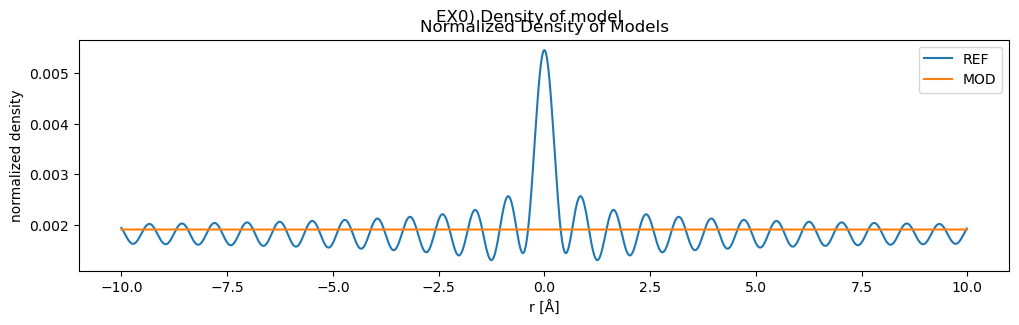

In [362]:
# AFF to n(r)
def EX0_Density():
    plt.figure(figsize = (12,3))
    # plt.subplot(1,2,1)
    R   = np.arange(-10, 10, 0.01) # Å unit
    XRD = Detector(CuKa1, atom = O)
    nG_ref  = XRD.AFF(REF=True)
    nG_mod  = XRD.AFF(REF=False)
    GG  = XRD.DK
    nR_ref = []
    nR_mod = []
    for r in R:
        nR_ref.append( np.sum(nG_ref) + np.sum(nG_ref * exp(-1j * GG * r))+np.sum(nG_ref * exp(1j * GG * r)) )
        nR_mod.append( np.sum(nG_mod) + np.sum(nG_mod * exp(-1j * GG * r))+np.sum(nG_mod * exp(1j * GG * r)) )
    print('Imaginary Part : (', norm(np.imag(nR_ref)), ',', norm(np.imag(nR_mod)), ')')
    (nR_ref, nR_mod) = map(np.real, [nR_ref, nR_mod])
    plt.plot(R, nR_ref/np.mean(nR_ref) * O.Z/(4/3 * pi * np.max(np.abs(R))**3), label = 'REF')
    plt.plot(R, nR_mod/np.mean(nR_mod) * O.Z/(4/3 * pi * np.max(np.abs(R))**3), label = 'MOD')
    # plt.plot(R, np.zeros_like(R), linestyle='dashed', linewidth=1)
    plt.legend()
    plt.title('Normalized Density of Models')
    plt.xlabel('r [Å]')
    plt.ylabel('normalized density')
    plt.suptitle('EX0) Density of model')
EX0_Density()

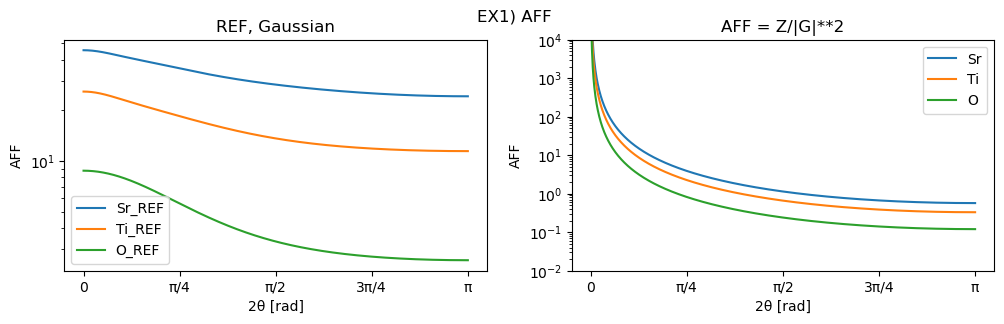

In [363]:
plt.figure(figsize=(12,3))
def EX1_AFF():
    XRD = Detector(CuKa1, atom = [Sr, Ti, O])
    AFF = XRD.AFF(REF=True)
    plt.subplot(1,2,1)
    plt.semilogy(XRD.TTHETA, AFF[0], label='Sr_REF')
    plt.semilogy(XRD.TTHETA, AFF[1], label='Ti_REF')
    plt.semilogy(XRD.TTHETA, AFF[2], label='O_REF')
    plt.xticks(*PIticks(0, 1, 1/4))
    plt.legend()
    plt.xlabel('2θ [rad]')
    plt.ylabel('AFF')
    plt.title('REF, Gaussian')
    # plt.title(f'EX1) AFF')
    plt.subplot(1,2,2)
    AFF = XRD.AFF(REF=False)
    plt.semilogy(XRD.TTHETA, AFF[0], label='Sr')
    plt.semilogy(XRD.TTHETA, AFF[1], label='Ti')
    plt.semilogy(XRD.TTHETA, AFF[2], label='O')
    plt.xticks(*PIticks(0, 1, 1/4))
    plt.legend()
    plt.xlabel('2θ [rad]')
    plt.ylabel('AFF')
    plt.ylim([1E-2, 1E4])
    plt.title('AFF = Z/|G|**2')
    plt.suptitle(f'EX1) AFF')
EX1_AFF()

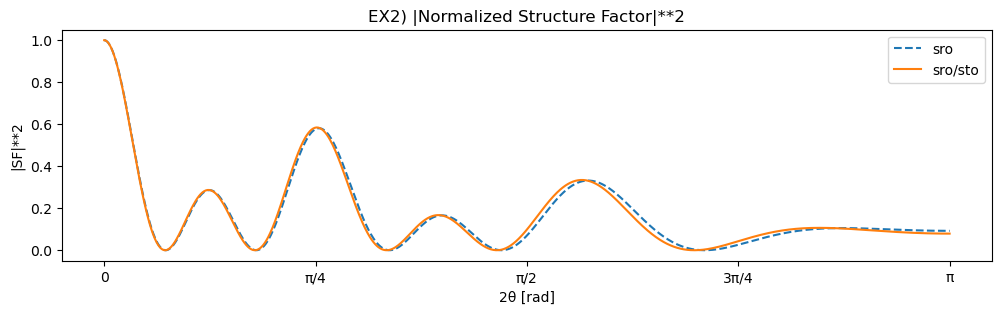

In [364]:
def EX2_SF(REF=True):
    plt.figure(figsize=(12, 3))
    XRD = Detector(CuKa1, molecule=[sro, sro_sto])
    XRD.align(nref = [sro(0,0,1), sro_sto(0,0,1)])
    SF  = XRD.SF()
    plt.plot(XRD.TTHETA, np.abs(SF[0])**2/np.max(np.abs(SF[0])**2), label='sro', linestyle='dashed')
    plt.plot(XRD.TTHETA, np.abs(SF[1])**2/np.max(np.abs(SF[1])**2), label='sro/sto')
    plt.legend()
    plt.xticks(*PIticks(0, 1, 1/4))
    plt.xlabel('2θ [rad]')
    plt.ylabel('|SF|**2')
    plt.title(f'EX2) |Normalized Structure Factor|**2')
EX2_SF()

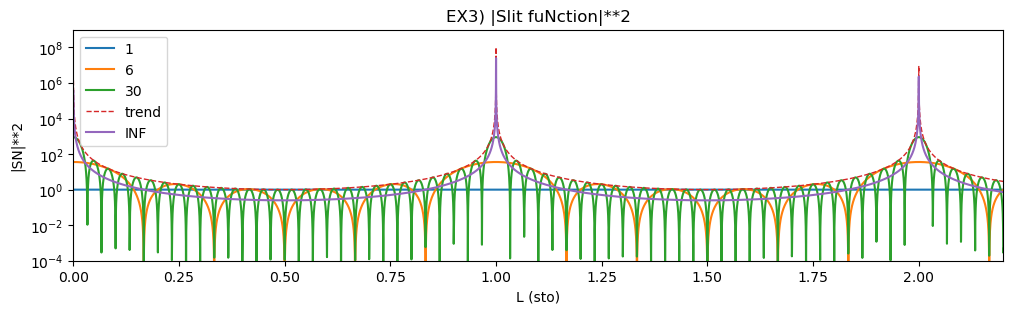

In [365]:
def EX3_SN():
    plt.figure(figsize=(12,3))    
    STO_GEN = lambda N: Film(sto, (1, 1, N))
    XRD = Detector(CuKa1, film=[STO_GEN(1), STO_GEN(6), STO_GEN(30), STO_GEN(inf)])
    XRD.align(STO(0,0,1))
    XRD.tthetaChange(np.linspace(0, pi/3, 10**4))
    SN  = XRD.SN()
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(SN[0])**2, label='1')
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(SN[1])**2, label='6')
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(SN[2])**2, label='30')
    plt.semilogy(XRD.HKL[STO()][:,2], 4*np.abs(SN[3])**2, label='trend', linewidth=1, linestyle='dashed')
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(SN[3])**2, label='INF')
    plt.legend()
    plt.xlabel('L (sto)')
    plt.ylabel('|SN|**2')
    plt.title(f'EX3) |Slit fuNction|**2')
    plt.xlim([0, 2.2])
    plt.ylim([0.0001, 1E9])
    #
    HKL = XRD.HKL[STO()]
    IX  = 2j * pi * HKL
EX3_SN()

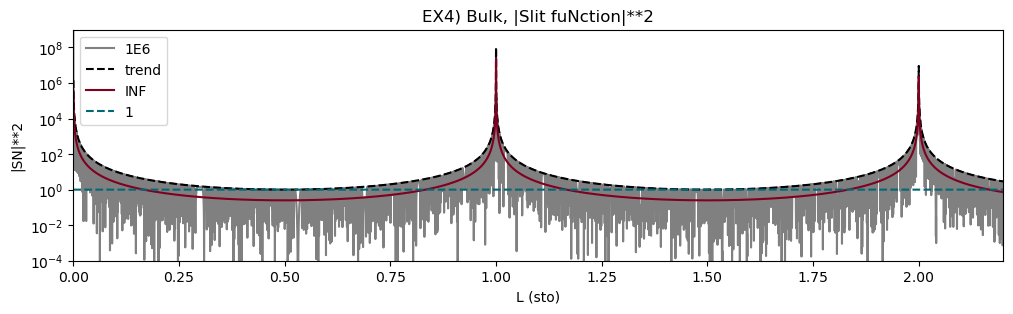

In [366]:
def EX4_BULK():
    plt.figure(figsize=(12,3))    
    STO_GEN = lambda N: Film(sto, (1, 1, N))
    XRD = Detector(CuKa1, film=[STO_GEN(1), STO_GEN(1E6), STO_GEN(inf)])
    XRD.align(STO(0,0,1))
    XRD.tthetaChange(np.linspace(0, pi/3, 10**4))
    SN  = XRD.SN()
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(SN[1])**2, label='1E6', color='grey')
    plt.semilogy(XRD.HKL[STO()][:,2], 4*np.abs(SN[2])**2, label='trend', linestyle='dashed', color='black')
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(SN[2])**2, label='INF', color='#800020')
    plt.semilogy(XRD.HKL[STO()][:,2], np.abs(SN[0])**2, label='1', color='#026873', linestyle='dashed')
    # plt.xlim([0,2.2])
    plt.legend()
    plt.xlabel('L (sto)')
    plt.ylabel('|SN|**2')
    plt.title(f'EX4) Bulk, |Slit fuNction|**2')
    plt.xlim([0, 2.2])
    plt.ylim([0.0001, 1E9])
EX4_BULK()

max :  1.0000000000000004
min :  0.9999999999999994


/Users/seongsihun/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


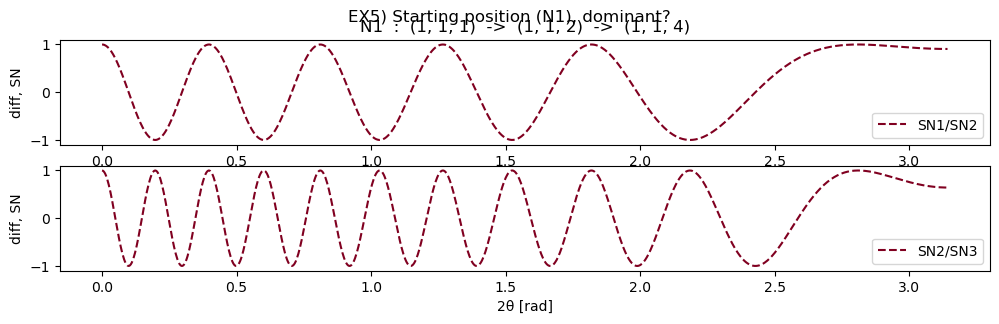

In [367]:
def EX5_START_LOC():
    plt.figure(figsize=(12, 3))
    XRD = Detector(CuKa1, film=Film(sto, (1,1,1)))
    XRD.align(STO(0,0,1))
    N01 = XRD.loc
    SN1 = XRD.SN()
    N02 = XRD.loc
    SN2 = XRD.SN()
    XRD.SN()
    N03 = XRD.loc
    SN3 = XRD.SN()
    plt.subplot(2,1,1)
    plt.plot(XRD.TTHETA, SN1/SN2, linestyle='dashed', label='SN1/SN2', color='#800020')
    plt.ylabel("diff, SN")
    # plt.ylim([0.999, 1.001])
    plt.title(f'N1  :  {tuple(N01)}  ->  {tuple(N02)}  ->  {tuple(N03)}')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(XRD.TTHETA, SN2/SN3, linestyle='dashed', label='SN2/SN3', color='#800020')
    plt.suptitle('EX5) Starting position (N1), dominant?')
    plt.xlabel("2θ [rad]")
    plt.ylabel("diff, SN")
    # plt.ylim([0.999, 1.001])
    plt.legend()
    print('max : ', np.max(np.abs(SN1/SN2)))
    print('min : ', np.min(np.abs(SN1/SN2)))
EX5_START_LOC()

max :  1.0000000000000007
min :  0.9999999999999993


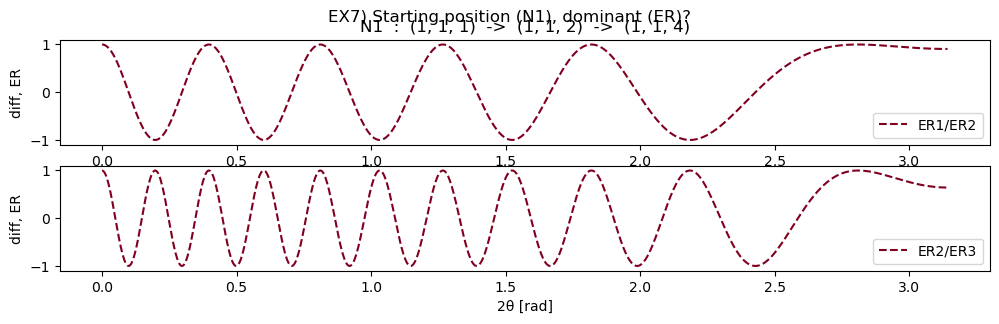

In [368]:
def EX7_START_LOC2():
    plt.figure(figsize=(12, 3))
    XRD = Detector(CuKa1, film=Film(sto, (1,1,1)))
    XRD.align(STO(0,0,1))
    N01 = XRD.loc
    ER1 = XRD.ER()
    N02 = XRD.loc
    ER2 = XRD.ER()
    XRD.ER()
    N03 = XRD.loc
    ER3 = XRD.ER()
    plt.subplot(2,1,1)
    plt.plot(XRD.TTHETA, ER1/ER2, linestyle='dashed', label='ER1/ER2', color='#800020')
    plt.ylabel("diff, ER")
    # plt.ylim([0.999, 1.001])
    plt.title(f'N1  :  {tuple(N01)}  ->  {tuple(N02)}  ->  {tuple(N03)}')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(XRD.TTHETA, ER2/ER3, linestyle='dashed', label='ER2/ER3', color='#800020')
    plt.suptitle('EX7) Starting position (N1), dominant (ER)?')
    plt.xlabel("2θ [rad]")
    plt.ylabel("diff, ER")
    # plt.ylim([0.999, 1.001])
    plt.legend()
    print('max : ', np.max(np.abs(ER1/ER2)))
    print('min : ', np.min(np.abs(ER1/ER2)))
EX7_START_LOC2()

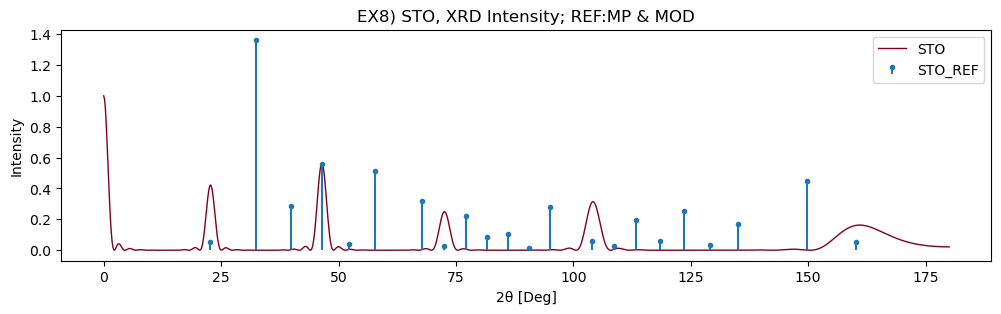

In [369]:
plt.figure(figsize=(12,3))
def EX8_STO():
    XRD = Detector(CuKa1, film = Film(sto, (10, 10, 10)))
    # XRD.degreeChange(5, 40, 1000)
    XRD.align(sto(0,0,1))
    ER = XRD.ER()
    plt.plot(XRD.DEGREE, np.abs(ER)**2/np.max(np.abs(ER)**2), color='#800020', linewidth=1, label='STO')
    # plt.semilogy(XRD.DEGREE, np.abs(ER)**2)
    X = np.rad2deg(asin(vec(1,2,3,4, 5)* CuKa1.wavelength / (2 * sto.abc[0]))) * 2
    # plt.plot(X, 0.58*vec(1,1,1,1,1), marker = '*', linewidth=0, color='red', label='PEAK')
EX8_STO()

def EX8_STO_REF():
    refTT = [
		22.727, 32.358, 39.908, 46.415, 52.281, 57.714,
		67.734, 72.469, 77.080, 81.608, 86.084, 90.534,
		94.990, 104.020, 108.657, 113.425, 118.372,
		123.562, 129.082, 135.082, 149.701, 160.228
	]
    refII = vec(*[
		3.873, 100, 21.139, 41.050, 2.922, 37.552,
		23.389, 1.868, 16.178, 6.325, 7.758, 1.036,
		20.784, 4.344, 1.918, 14.290, 4.367, 18.671,
		2.388, 12.534, 32.811, 3.766
	])
    # . , o v ^ < > 1 2 3 4 s p * h H + x D d _
    plt.stem(refTT, refII/100*1.36, label='STO_REF', markerfmt='.', basefmt=' ')
    # plt.ylim([0, 0.6])
    plt.xlabel('2θ [Deg]')
    plt.ylabel('Intensity')
    plt.title('EX8) STO, XRD Intensity; REF:MP & MOD')
    plt.legend()
EX8_STO_REF()

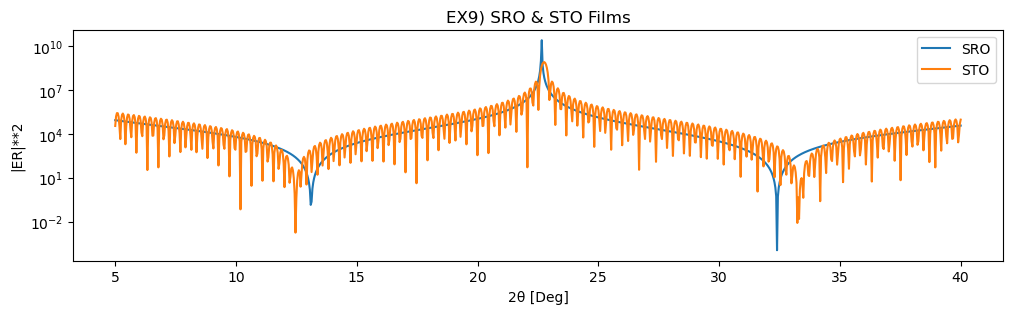

In [370]:
def EX9_SRO_sto():
    plt.figure(figsize=(12,3))
    N = 100
    XRD = Detector(CuKa1, film=[Film(sro, (1, 1, inf)), Film(sto, (1, 1, N))])
    XRD.align([sro(0,0,1), sto(0,0,1)])
    XRD.degreeChange(5, 40, 1000)
    ER  = XRD.ER()
    plt.semilogy(XRD.DEGREE, np.abs(ER[0])**2, label='SRO')
    plt.semilogy(XRD.DEGREE, np.abs(ER[1])**2, label='STO')
    plt.legend()
    plt.xlabel('2θ [Deg]')
    plt.ylabel('|ER|**2')
    plt.title(f'EX9) SRO & STO Films')
EX9_SRO_sto()

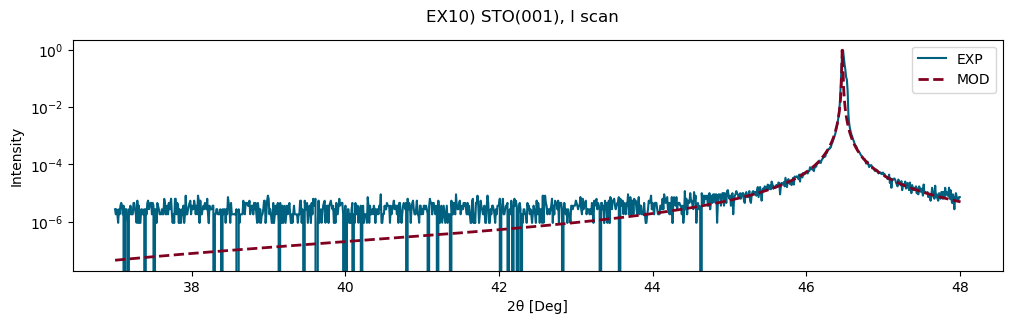

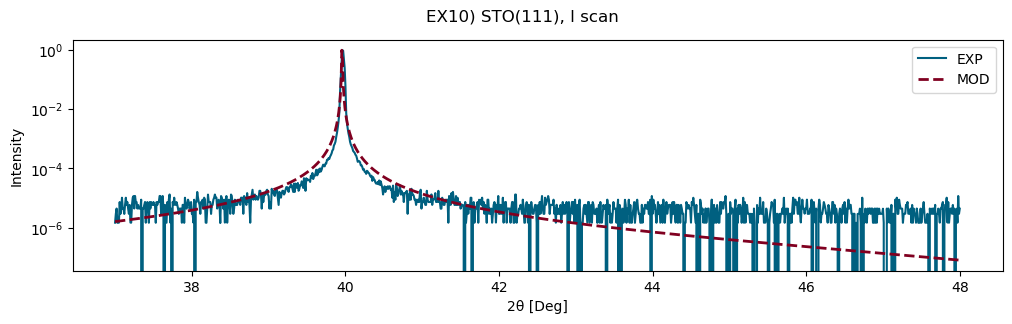

In [371]:
def EX10_EXP():
	file_path = "./JSON/RAWDATA.json"  # 파일 경로
	with open(file_path, "r") as f:
		RAWDATA = json.load(f)
	RAWDATA001 = RAWDATA["STO001"]
	RAWDATA111 = RAWDATA["STO111"]

	plt.figure(figsize=(12,3))
	plt.suptitle("EX10) STO(001), l scan")
	# plt.subplot(1,2,1)
	expTT = np.arange(37, 48.01, 0.01)
	expII = RAWDATA001
	plt.semilogy(expTT, expII/np.max(expII), label='EXP', color='#006080')
	#
	# plt.subplot(1,2,2)
	XRD = Detector(CuKa1, film=Film(sto,(1,1,inf)))
	XRD.align(sto(0,0,1))
	XRD.degreeChange(37, 48.01, 1101)
	ER  = XRD.ER()
	plt.semilogy(XRD.DEGREE, np.abs(ER)**2/np.max(np.abs(ER)**2), linestyle='dashed', linewidth=2, color='#800020', label='MOD')
	plt.legend()
	plt.xlabel('2θ [Deg]')
	plt.ylabel('Intensity')
	plt.figure(figsize=(12,3))
	plt.suptitle("EX10) STO(111), l scan")
	# plt.subplot(1,2,1)
	expTT = np.arange(37, 48.01, 0.01)
	expII = RAWDATA111
	plt.semilogy(expTT, expII/np.max(expII), label='EXP', color='#006080')
	#
	# plt.subplot(1,2,2)
	XRD = Detector(CuKa1, film=Film(sto,(1,1,inf)))
	XRD.align(sto(1,1,1))
	XRD.degreeChange(37, 48.01, 1101)
	ER  = XRD.ER()
	plt.semilogy(XRD.DEGREE, np.abs(ER)**2/np.max(np.abs(ER)**2), linestyle='dashed', linewidth=2, color='#800020', label='MOD')
	plt.legend()
	plt.xlabel('2θ [Deg]')
	plt.ylabel('Intensity')
EX10_EXP()

Imaginary Part : 20411055026361.13


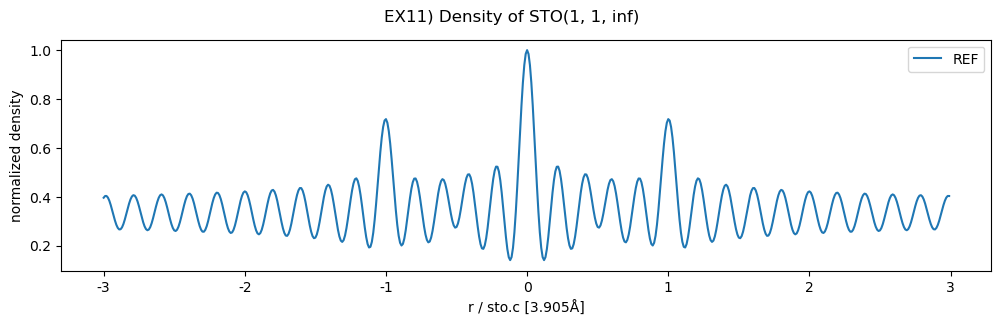

In [707]:
# AFF to n(r)
def EX11_Density():
    plt.figure(figsize = (12,3))
    R   = 3.905 * np.arange(-3, 3, 0.01) # Å unit
    XRD = Detector(CuKa1, film=Film(sto, (1,1,inf)))
    XRD.align(STO(0,0,1))
    ER  = XRD.ER()
    GG  = XRD.DK
    nR_ref = []
    for r in R:
        nR_ref.append( np.sum(ER) + np.sum(ER * exp(-1j * GG * r))+np.sum(ER * exp(1j * GG * r)) )
    print(f'Imaginary Part : {norm(np.imag(nR_ref))}')
    nR_ref = np.real(nR_ref)
    plt.plot(R, nR_ref/np.max(nR_ref), label = 'REF')
    plt.legend()
    plt.xticks(np.arange(-3, 4, 1) * 3.905, np.arange(-3, 4, 1))
    plt.xlabel('r / sto.c [3.905Å]')
    plt.ylabel('normalized density')
    plt.suptitle('EX11) Density of STO(1, 1, inf)')
EX11_Density()